In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
len(np.unique(labels))

5

## attemptng with melspec

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

# Framing
SAMPLE_RATE = 22050
SIGNAL_LENGTH = 5  # Length of audio chunks
SPEC_SHAPE = (128, 64)  # Shape of mel spectrograms (height, width)
FMIN = 20  # Minimum frequency for mel spectrogram
FMAX = SAMPLE_RATE // 2
# Define function to extract mel spectrograms from an audio file and save as images
def get_mel_spectrograms(filepath, primary_label, output_dir):
    # Load the audio file using librosa (limit to first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, duration=15)

    # Split signal into chunks of 5 seconds each
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # Break if split is shorter than required
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break

        sig_splits.append(split)

    # Extract mel spectrograms for each chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(
            y=chunk,
            sr=SAMPLE_RATE,
            n_fft=1024,
            hop_length=hop_length,
            n_mels=SPEC_SHAPE[0],
            fmin=FMIN,
            fmax=FMAX
        )

        # decibels and normalization
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()


        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"{filepath.split(os.sep)[-1].rsplit('.', 1)[0]}_{s_cnt}.png")
        im = Image.fromarray((mel_spec * 255.0).astype(np.uint8)).convert("L")
        im.save(save_path)

        saved_samples.append(save_path)
        s_cnt += 1

    return saved_samples

# Load data and extract mel spectrograms
def load_data(data_path, output_path):
    data = []
    labels = []
    # list of classes
    class_folders = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

    # Create label mapping
    label_mapping = {class_folder: idx for idx, class_folder in enumerate(class_folders)}

    # processing the audio and then obtaining the mel spectrograms
    samples = []
    for class_folder in class_folders:
        class_path = os.path.join(data_path, class_folder)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                # Extract mel spectrograms and save as images
                saved_samples = get_mel_spectrograms(file_path, class_folder, output_path)
                samples.extend(saved_samples)

    # Load images and labels from the saved spectrograms
    for sample in samples:
        # Load the spectrogram image
        img = load_img(sample, color_mode='grayscale', target_size=(SPEC_SHAPE[0], SPEC_SHAPE[1]))
        # Convert the image to a numpy array and normalize it
        img_array = img_to_array(img) / 255.0
        data.append(img_array)

        # Extract the label from the file path
        label = sample.split(os.sep)[-2]
        labels.append(label_mapping[label])


    data = np.array(data, dtype=np.float32)
    labels = np.array(labels)

    return data, labels


data_path = '/content/drive/MyDrive/Envision2024/dataset'
output_path = '/content/drive/MyDrive/Envision2024/birdcall_mel_spectrograms'

data, labels = load_data(data_path, output_path)

labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))


X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/15
8/8 [==============================] - 7s 102ms/step - loss: 1.6128 - accuracy: 0.2217 - val_loss: 1.5929 - val_accuracy: 0.3448
Epoch 2/15
8/8 [==============================] - 0s 14ms/step - loss: 1.5939 - accuracy: 0.2870 - val_loss: 1.5630 - val_accuracy: 0.2586
Epoch 3/15
8/8 [==============================] - 0s 13ms/step - loss: 1.5152 - accuracy: 0.3522 - val_loss: 1.3967 - val_accuracy: 0.3793
Epoch 4/15
8/8 [==============================] - 0s 14ms/step - loss: 1.4283 - accuracy: 0.3696 - val_loss: 1.2909 - val_accuracy: 0.4310
Epoch 5/15
8/8 [==============================] - 0s 13ms/step - loss: 1.3353 - accuracy: 0.4609 - val_loss: 1.1714 - val_accuracy: 0.5862
Epoch 6/15
8/8 [==============================] - 0s 13ms/step - loss: 1.1305 - accuracy: 0.5783 - val_loss: 0.9233 - val_accuracy: 0.6897
Epoch 7/15
8/8 [==============================] - 0s 14ms/step - loss: 0.9925 - accuracy: 0.5913 - val_loss: 0.8762 - val_accuracy: 0.5862
Epoch 8/15
8/8 [==========

## Plotting the Mel-Spectrograms

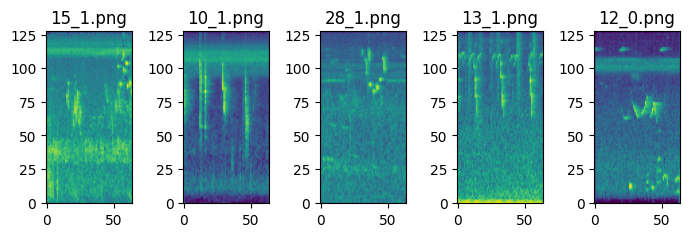

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image


output_path = '/content/drive/MyDrive/birdcall_mel_spectrograms'
# Function to randomly select and plot mel spectrograms
def plot_random_spectrograms(output_path, num_spectrograms=5):
    # Get a list of all image files in the output directory and subdirectories
    spectrogram_files = []
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith('.png'):
                spectrogram_files.append(os.path.join(root, file))

    # Randomly selecting `num_spectrograms` files from the list
    selected_files = random.sample(spectrogram_files, num_spectrograms)

    # Plotting the selected spectrograms
    plt.figure(figsize=(7, 7))
    for i, file_path in enumerate(selected_files):

        spec = Image.open(file_path)

        plt.subplot(1, num_spectrograms, i + 1)
        plt.title(file_path.split(os.sep)[-1])
        plt.imshow(spec, origin='lower', cmap='viridis')


    plt.tight_layout()
    plt.show()

plot_random_spectrograms(output_path, num_spectrograms=5)


In [ ]:
np.save(f"/content/drive/MyDrive/Envision2024/data/mel_data", data)
np.save(f"/content/drive/MyDrive/Envision2024/data/labels_data", labels)

In [ ]:
np.load('/content/drive/MyDrive/Envision2024/data/mel_data.npy')
np.load('/content/drive/MyDrive/Envision2024/data/labels_data.npy')


In [ ]:
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
SPEC_SHAPE = (128, 64)

labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])



# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


f1_score=F1Score(num_classes=len(np.unique(labels)),average='macro',name='f1_score')

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [
            early_stopping,
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_4.h5',

                                                verbose=1,
                                                save_best_only=True)]


his=model.fit(X_train, y_train, batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=100)

test_loss, test_accuracy, test_f1_score = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 63, 31, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 63, 31, 32)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 30, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 28, 12, 128)     

In [ ]:
print(f"Test acc: {test_accuracy:.4f}")

Test acc: 0.8889


In [ ]:
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))

    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')

    #accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')

#     #f1_score
#     plt.plot(range(len(his)),his['f1_score'],color='steelblue',label='training_f1')
#     plt.plot(range(len(his)),his['val_f1_score'],color='maroon',label='validation_f1')

    plt.legend()
    plt.title('accuracy')

    plt.show()

In [ ]:
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
SPEC_SHAPE = (128, 64)

labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Flatten(),
    # Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])





# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


f1_score=F1Score(num_classes=len(np.unique(labels)),average='macro',name='f1_score')

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [
            early_stopping,
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_4.h5',

                                                verbose=1,
                                                save_best_only=True)]


his=model.fit(X_train, y_train, batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=100)

test_loss, test_accuracy, test_f1_score = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test acc: {test_accuracy:.4f}")

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_148 (Conv2D)         (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d_148 (MaxPool  (None, 63, 31, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_54 (Dropout)        (None, 63, 31, 32)        0         
                                                                 
 conv2d_149 (Conv2D)         (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_149 (MaxPool  (None, 30, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_150 (Conv2D)         (None, 28, 12, 64)      

In [ ]:
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
SPEC_SHAPE = (128, 64)

labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])





# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


f1_score=F1Score(num_classes=len(np.unique(labels)),average='macro',name='f1_score')

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [
            early_stopping,
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_4.h5',

                                                verbose=1,
                                                save_best_only=True)]


his=model.fit(X_train, y_train, batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=100)

test_loss, test_accuracy, test_f1_score = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test acc: {test_accuracy:.4f}")

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_153 (Conv2D)         (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d_153 (MaxPool  (None, 63, 31, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_56 (Dropout)        (None, 63, 31, 32)        0         
                                                                 
 conv2d_154 (Conv2D)         (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_154 (MaxPool  (None, 30, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_155 (Conv2D)         (None, 28, 12, 64)      

In [ ]:
print(f"Test acc: {test_accuracy:.4f}")

Test acc: 0.8750


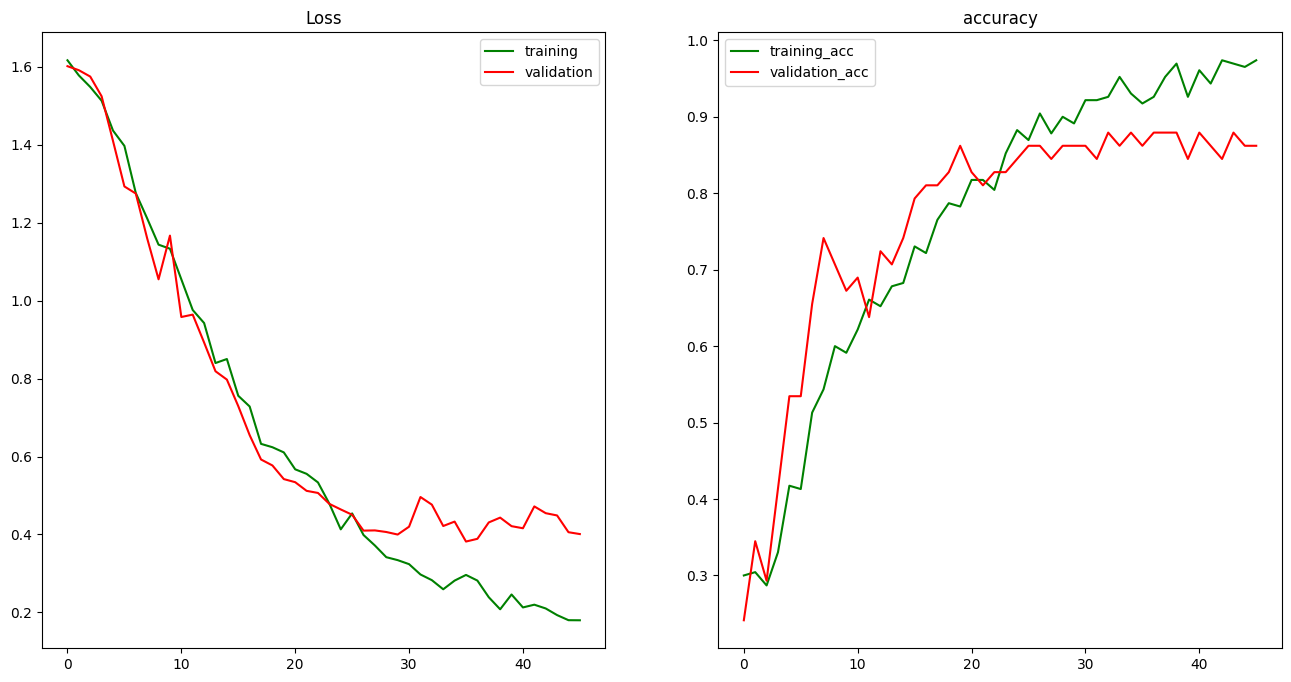

In [ ]:
plot_history(his)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))

    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')

    #accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')

#     #f1_score
#     plt.plot(range(len(his)),his['f1_score'],color='steelblue',label='training_f1')
#     plt.plot(range(len(his)),his['val_f1_score'],color='maroon',label='validation_f1')

    plt.legend()
    plt.title('accuracy')

    plt.show()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_339 (Conv2D)         (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d_339 (MaxPool  (None, 63, 31, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_180 (Dropout)       (None, 63, 31, 32)        0         
                                                                 
 conv2d_340 (Conv2D)         (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_340 (MaxPool  (None, 30, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_341 (Conv2D)         (None, 28, 12, 128)    

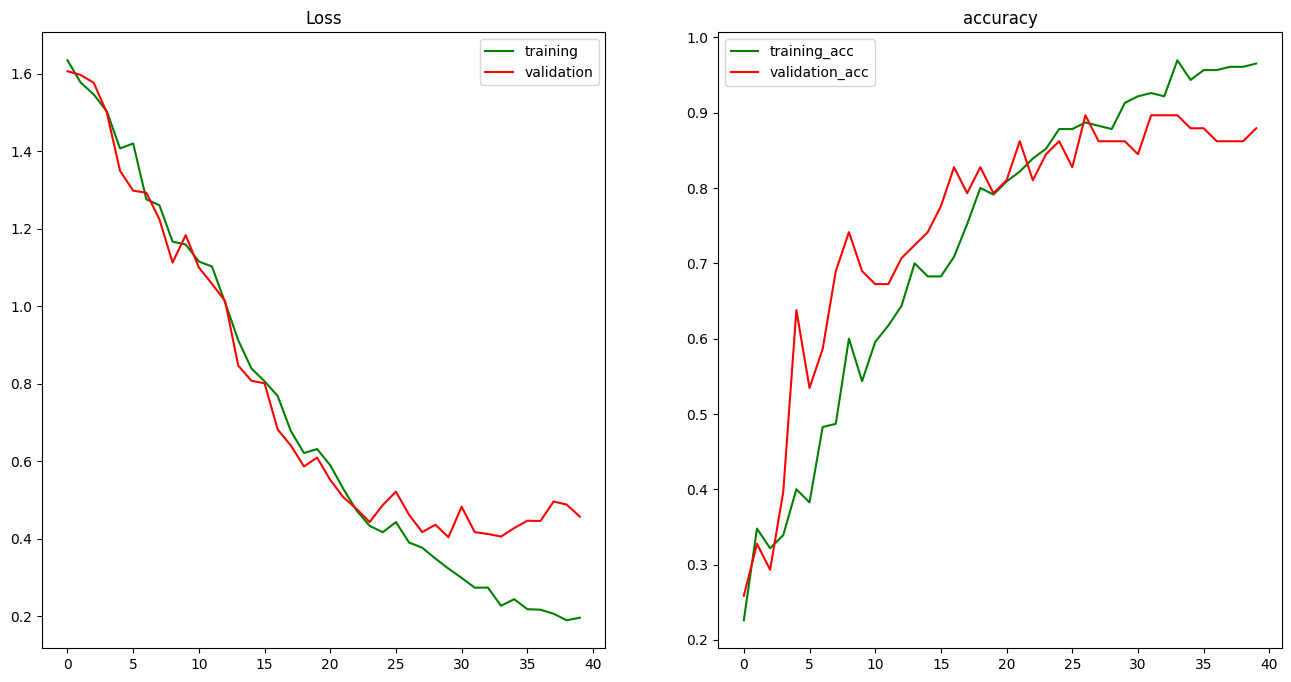

In [ ]:
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
SPEC_SHAPE = (128, 64)

labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])



# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


f1_score=F1Score(num_classes=len(np.unique(labels)),average='macro',name='f1_score')

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [
            early_stopping,
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_4.h5',

                                                verbose=1,
                                                save_best_only=True)]


his1=model.fit(X_train, y_train, batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=100)

test_loss, test_accuracy, test_f1_score = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test acc: {test_accuracy:.4f}")

plot_history(his1)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


model.save("/content/drive/MyDrive/Envision2024/models/final_model.keras")

3/3 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.95      0.95      0.95        21
           2       0.73      0.85      0.79        13
           3       0.73      1.00      0.84         8
           4       0.85      0.73      0.79        15

    accuracy                           0.86        72
   macro avg       0.85      0.87      0.85        72
weighted avg       0.88      0.86      0.86        72



In [ ]:
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
SPEC_SHAPE = (128, 64)

labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])





# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


f1_score=F1Score(num_classes=len(np.unique(labels)),average='macro',name='f1_score')

model1.summary()
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [
            early_stopping,
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_new.h5',

                                                verbose=1,
                                                save_best_only=True)]


his=model1.fit(X_train, y_train, batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=100)

test_loss, test_accuracy, test_f1_score = model1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test acc: {test_accuracy:.4f}")

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_216 (Conv2D)         (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d_216 (MaxPool  (None, 63, 31, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_98 (Dropout)        (None, 63, 31, 32)        0         
                                                                 
 conv2d_217 (Conv2D)         (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_217 (MaxPool  (None, 30, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_218 (Conv2D)         (None, 28, 12, 64)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 23ms/step - loss: 1.5823 - accuracy: 0.2870 - f1_score: 0.1599 - val_loss: 1.5908 - val_accuracy: 0.3103 - val_f1_score: 0.1912
Epoch 3/100
5/8 [=================>............] - ETA: 0s - loss: 1.5567 - accuracy: 0.3187 - f1_score: 0.1995
Epoch 3: val_loss improved from 1.59079 to 1.57162, saving model to best_model_new.h5
8/8 [==============================] - 0s 23ms/step - loss: 1.5603 - accuracy: 0.2957 - f1_score: 0.1783 - val_loss: 1.5716 - val_accuracy: 0.3103 - val_f1_score: 0.2043
Epoch 4/100
5/8 [=================>............] - ETA: 0s - loss: 1.5414 - accuracy: 0.3375 - f1_score: 0.2033
Epoch 4: val_loss improved from 1.57162 to 1.51629, saving model to best_model_new.h5
8/8 [==============================] - 0s 23ms/step - loss: 1.5309 - accuracy: 0.3435 - f1_score: 0.2092 - val_loss: 1.5163 - val_accuracy: 0.3966 - val_f1_score: 0.2409
Epoch 5/100
5/8 [=================>............] - ETA: 0s - loss: 1.4850 - accuracy: 0.4000 -

In [ ]:
from sklearn.metrics import classification_report
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))
model1.save("/content/drive/MyDrive/Envision2024/models/final_model_1.keras")

3/3 [==============================] - 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.91      0.95      0.93        21
           2       0.85      0.85      0.85        13
           3       0.73      1.00      0.84         8
           4       0.85      0.73      0.79        15

    accuracy                           0.86        72
   macro avg       0.85      0.87      0.85        72
weighted avg       0.87      0.86      0.86        72



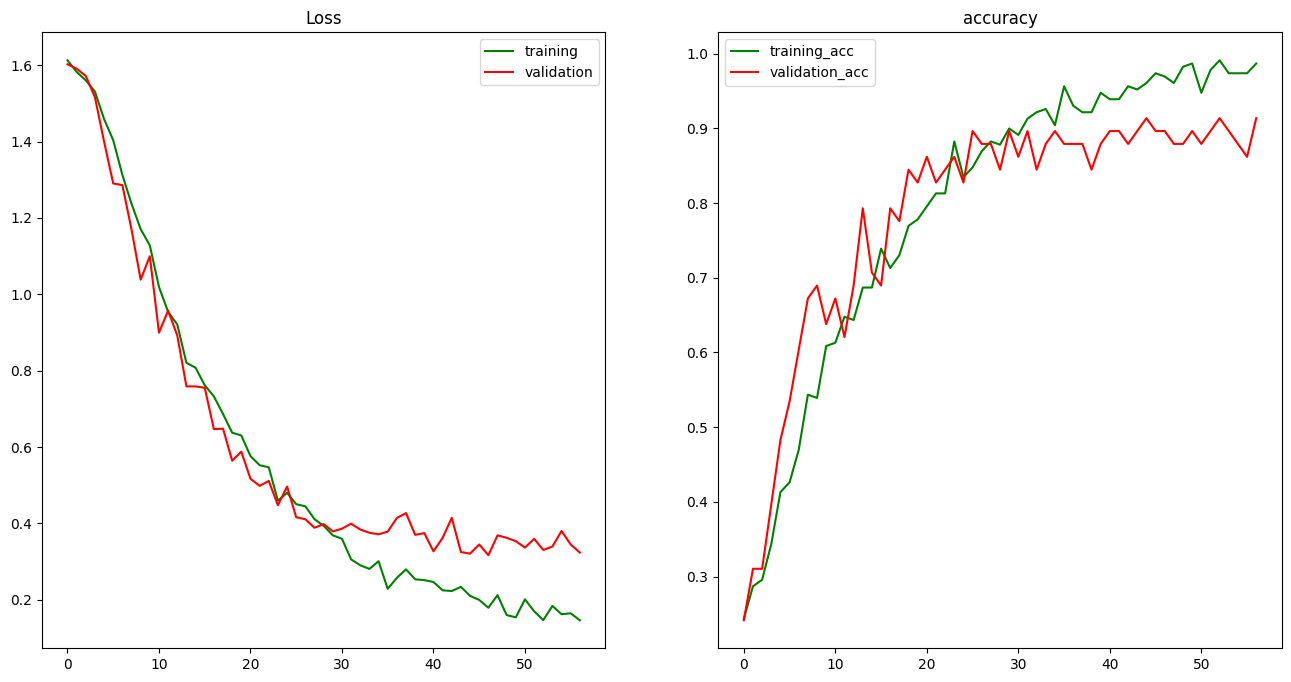

In [ ]:

plot_history(his)